In [10]:
import numpy as np
import matplotlib.pyplot as plt
from pdet import MZQbin

In [11]:
T_obs = 1
q = 0.5 # q = m2 / m1, with m2 <= m1
# Initialize the bins
bin1 = MZQbin(8, 13, 0.1, 0.15, q)
bin2 = MZQbin(8, 13, 0.2, 0.25, q)

# Set a Rate ratio and some reference values for the number of events in one of the bin
R1_R2 = 1
n2_min, n2_max = 10, 100
N_2_grid = np.array(range(n2_min, n2_max + 1))
N_2_ref = 60

# Confidence level
cl = 0.05

In [12]:
bin1.VTmc(T_obs), bin2.VTmc(T_obs), bin2.VT / bin1.VT

(np.float64(1515811887.4447289),
 np.float64(946233306.9969467),
 np.float64(0.6242419094575475))

In [13]:
N1_N2_target_sx, N1_N2_target_dx, N1_N2_0_ref, a = bin1.alphaLRT(bin2, cl, R1_R2, N_2_grid, T_obs)

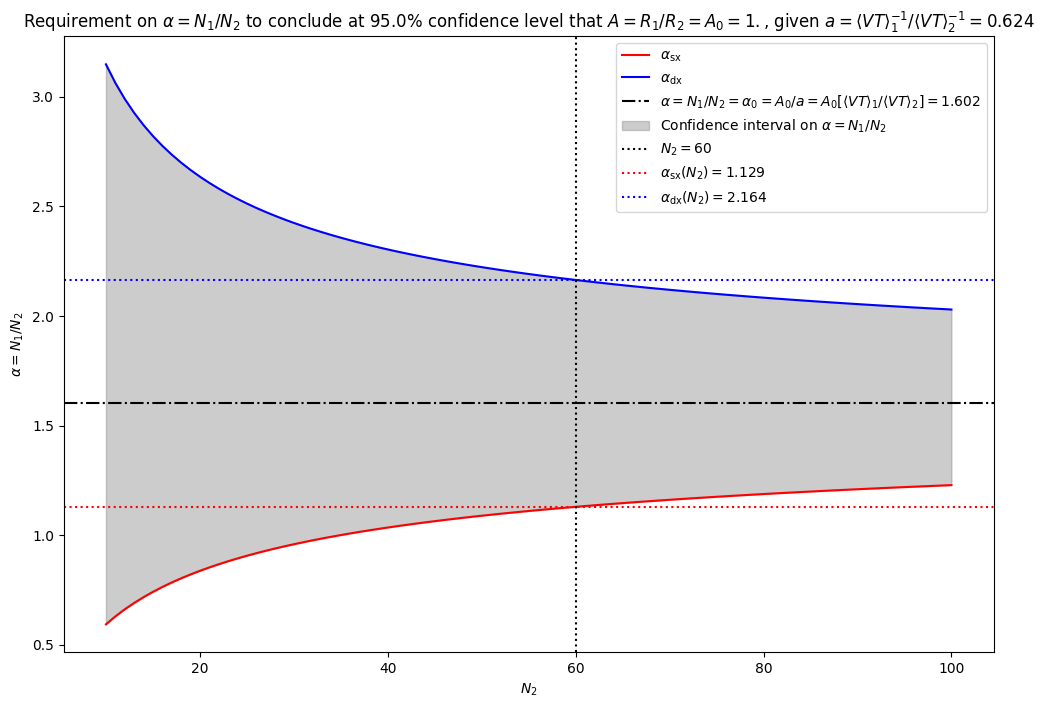

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'Requirement on $\alpha = N_1 / N_2$ to conclude at ${0}\%$ confidence level that $A = R_1 / R_2 = A_0 = {1}$, given $a = \langle VT \rangle_1^{{-1}} / \langle VT \rangle_2^{{-1}} = {2}$'.format((1 - cl) * 100,
                                                                                                                                                                                                                 np.format_float_positional(R1_R2, 3),
                                                                                                                                                                                                                 np.format_float_positional(a, 3)))

ax.set_xlabel(r'$N_2$')
ax.set_ylabel(r'$\alpha = N_1 / N_2$')

# alpha_target vs N_2
ax.plot(N_2_grid, N1_N2_target_sx, color='red', label=r'$\alpha_\text{sx}$')
ax.plot(N_2_grid, N1_N2_target_dx, color='blue', label=r'$\alpha_\text{dx}$')

# Central value of alpha_target for having A = A_0, at fixed a
ax.axhline(N1_N2_0_ref, linestyle='-.', color='black', label=r'$\alpha = N_1 / N_2 = \alpha_0 = A_0 / a = A_0 [\langle VT \rangle_1 / \langle VT \rangle_2] = {0}$'.format(np.format_float_positional(N1_N2_0_ref, 3)))

# Confidence interval
ax.fill_between(N_2_grid, N1_N2_target_sx, N1_N2_target_dx, color='gray', alpha=0.4, label=r'Confidence interval on $\alpha = N_1 / N_2$')

# Reference lines for the chosen N_2
ax.axvline(N_2_ref, linestyle=':', color='black', label=r'$N_2 = {0}$'.format(N_2_ref))
N_2_index = np.where(N_2_grid == N_2_ref)[0][0]
ax.axhline(N1_N2_target_sx[N_2_index], linestyle=':', color='red', label=r'$\alpha_\text{{sx}}(N_2) = {0}$'.format(np.format_float_positional(N1_N2_target_sx[N_2_index], 3)))
ax.axhline(N1_N2_target_dx[N_2_index], linestyle=':', color='blue', label=r'$\alpha_\text{{dx}}(N_2) = {0}$'.format(np.format_float_positional(N1_N2_target_dx[N_2_index], 3)))

ax.legend()

plt.show()

Based on bin_comparison_2, if we assume a Gamma distribution as the prior of the expectation value $\lambda$ of the Poisson distribution describing the content of a bin and we make a measurment, the posterior on $\lambda$ is again a Gamma distribution with modified parameters.

Then, the ratio of two Gamma distributed random variables is given by a [generalized Beta prime distribution](https://en.wikipedia.org/wiki/Beta_prime_distribution#Generalization).

Specifically: if $X_k \sim \Gamma(\alpha_k, \beta_k)$, $\dfrac{X_1}{X_2} = \beta'(\alpha_1, \alpha_2, 1, \dfrac{\beta_2}{\beta_1})$. See implementation in pdet.MZQbin.alphaBayes.

In [15]:
l1_l2_samples, N1_N2, a = bin1.alphaBayesHist(bin2, R1_R2, N_2_ref, T_obs)

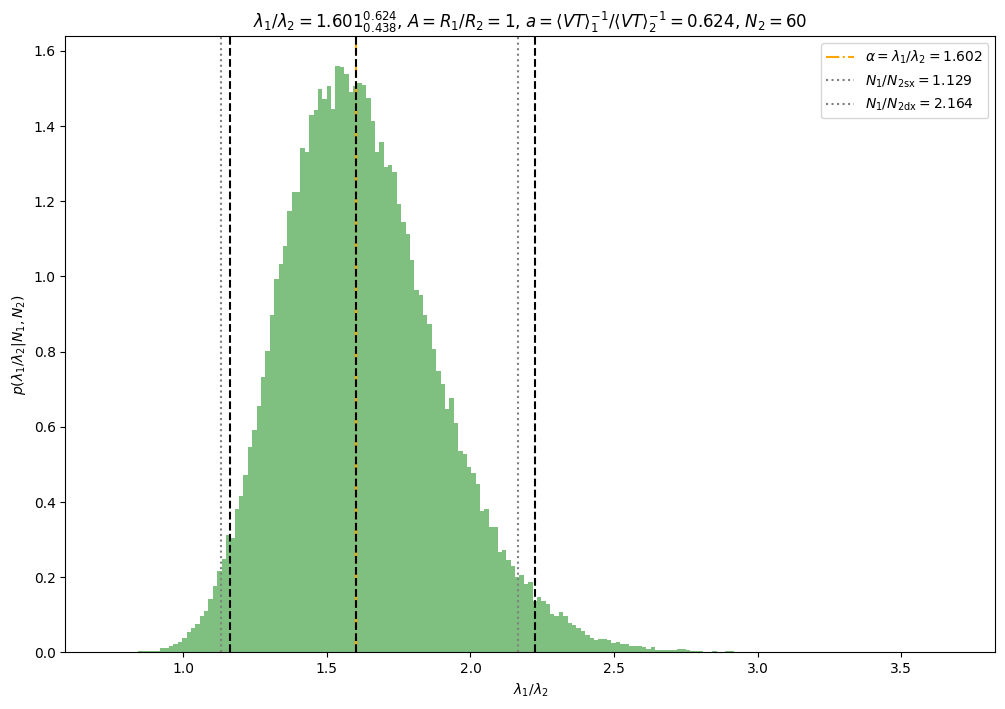

In [16]:
# Quantiles
quantiles = np.quantile(l1_l2_samples, [0.025, 0.5, 0.975])
quantiles_lb = np.copy(quantiles)
quantiles_lb[0] = quantiles_lb[1] - quantiles_lb[0]
quantiles_lb[2] = quantiles_lb[2] - quantiles_lb[1]

# PLOT
#---------------------------------------------
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'$\lambda_1 / \lambda_2 = {1}_{{{0}}}^{{{2}}}$, $A = R_1 / R_2 = {3}$, $a = \langle VT \rangle_1^{{-1}} / \langle VT \rangle_2^{{-1}} = {4}$, $N_2 = {5}$'.format(*[np.format_float_positional(_q, 3) for _q in quantiles_lb],
                                                                                                                                                                                R1_R2,
                                                                                                                                                                                np.format_float_positional(a, 3),
                                                                                                                                                                                N_2_ref))
ax.set_xlabel(r'$\lambda_1 / \lambda_2$')
ax.set_ylabel(r'$p(\lambda_1 / \lambda_2 | N_1, N_2)$')

# Posterior
ax.hist(l1_l2_samples, bins='auto', density=True, alpha=0.5, color='green')
# True value of A
ax.axvline((N1_N2), linestyle='-.', color='orange', label=r'$\alpha = \lambda_1 / \lambda_2 = {0}$'.format(np.format_float_positional(N1_N2, 3)))
# Quantiles
for _q in quantiles:
    ax.axvline(_q, linestyle='--', color='black')

#-----------------------------------------------------
# Confidence interval from the likelihood-ratio test
for _A, lb in zip([N1_N2_target_sx[N_2_index], N1_N2_target_dx[N_2_index]], [r'${{N_1 / N_2}}_\text{{sx}} = {0}$', r'${{N_1 / N_2}}_\text{{dx}} = {0}$']):
    ax.axvline(_A, linestyle=':', color='gray', label=lb.format(np.format_float_positional(_A, 3)))

ax.legend()

plt.show()

In [17]:
N2_list = [30, 60, 90]
alpha_hist = [bin1.alphaBayesHist(bin2, R1_R2, N2, T_obs)[0] for N2 in N2_list]

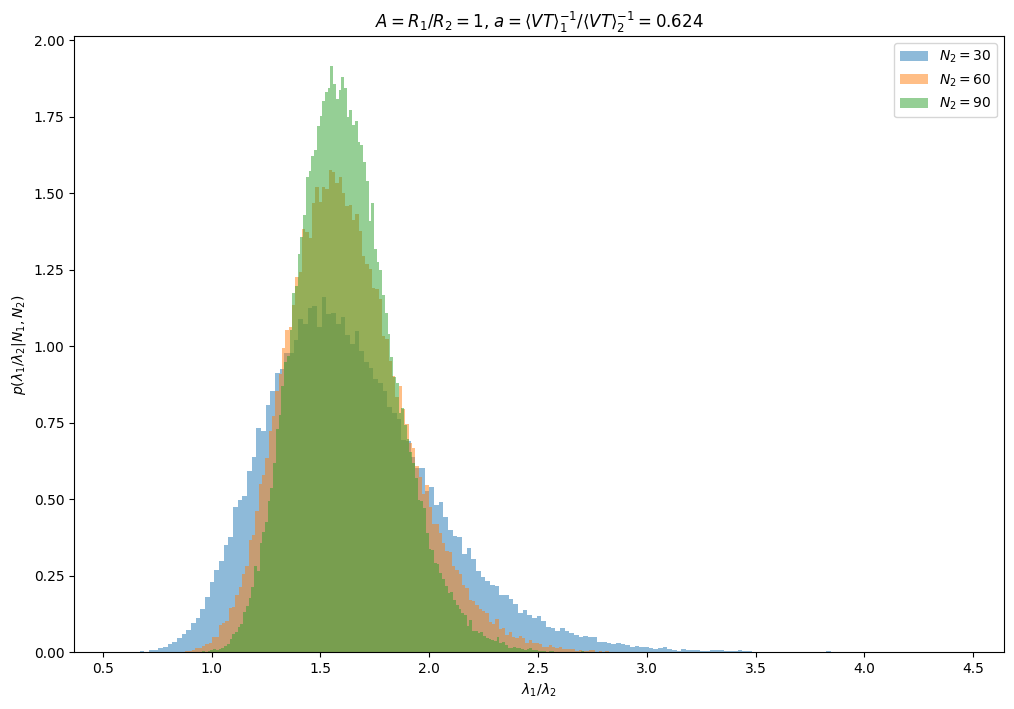

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'$A = R_1 / R_2 = {0}$, $a = \langle VT \rangle_1^{{-1}} / \langle VT \rangle_2^{{-1}} = {1}$'.format(R1_R2, np.format_float_positional(a, 3)))
ax.set_xlabel(r'$\lambda_1 / \lambda_2$')
ax.set_ylabel(r'$p(\lambda_1 / \lambda_2 | N_1, N_2)$')

# Posteriors
for samples, N2 in zip(alpha_hist, N2_list):
    ax.hist(samples, bins='auto', density=True, alpha=0.5, label=r'$N_2 = {0}$'.format(N2))

ax.legend()

plt.show()